# Выпускная классификационная работа
***
### Разработка модели машинного обучения для распознавания типов сельскохозяйственных культур, произростающих на территории Хабаровского края, на основе данных дистанционного зондирования Земли

*Датасет получен в рамках хакатона [ScienceDataLab2023](http://sciencedatalab.ccfebras.ru/).*

Для построения модели классификации будут использоваться сглаженные временные ряды вегетационного индекса *NDVI*,  рассчитанного с помощью оптических снимков, полученных со спутника Sentinel-2A.

Датасет состоит из точек, для которых известна информация о севообороте. В нем содержатся данные 11948 точек сельскохозяйственных полей Хабаровского края с указанием произрастающей культуры.

*Описание данных*:
- **Числовые столбцы** - значение индекса *NDVI* (принимает значение от -1 до 1) в день от начала года (название столбца <=> номер дня);
- **Culture** - название выращиваемой культуры.

*Список сельскохозяйственных культур*:

|Номер|Название культуры|
|-----|-----------------|
|1|залежь|
|2|соя|
|3|гречиха|
|4|пар|
|5|многолетние травы|
|6|овёс|
|7|кукуруза|
|8|капуста|
|9|картофель|
|10|пшеница|
|11|рапс|
|12|ячмень|

### Библиотеки

In [31]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install sklearn
# !pip install optuna
# !pip install geemap
# !pip install scipy
# !pip install lightgbm
# !pip install imblearn

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import optuna as opt
import geemap
import geemap.colormaps as cm
import os
import ee

from scipy.signal import savgol_filter
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline
sns.set_style("white")

import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [33]:
orig_df = pd.read_csv('data/dataset.csv')
orig_df = orig_df.drop(['n'], axis=1) # удаляем лишний столбец индекса

orig_df

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture
0,0.152669,0.174438,0.209893,0.256847,0.311688,0.369805,0.426172,0.475995,0.515328,0.541544,...,0.408483,0.385844,0.365548,0.346269,0.326351,0.304307,0.279290,0.251440,0.222043,рапс
1,0.084050,0.086133,0.108377,0.150274,0.207985,0.274870,0.342531,0.402199,0.446191,0.469186,...,0.205599,0.198665,0.203006,0.213593,0.224371,0.229603,0.225114,0.209236,0.183238,овёс
2,0.096446,0.126057,0.176833,0.242489,0.314037,0.381269,0.434477,0.466086,0.471930,0.451926,...,0.172827,0.199820,0.232640,0.262798,0.282596,0.286615,0.272769,0.242751,0.201755,ячмень
3,0.179056,0.218924,0.273501,0.337271,0.403364,0.464549,0.514283,0.547656,0.562066,0.557534,...,0.345934,0.347316,0.351494,0.353862,0.350224,0.337656,0.315155,0.283937,0.247342,рапс
4,0.079677,0.089905,0.117176,0.159635,0.213100,0.271661,0.328564,0.377248,0.412350,0.430514,...,0.240325,0.233890,0.234504,0.238449,0.241388,0.239296,0.229331,0.210486,0.183892,овёс
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11943,0.163391,0.143697,0.120005,0.100573,0.093871,0.106969,0.144125,0.205823,0.288415,0.384453,...,0.516079,0.413483,0.307684,0.210348,0.131209,0.076724,0.049286,0.047101,0.064746,кукуруза
11944,0.147970,0.150326,0.152982,0.160208,0.176418,0.205235,0.248674,0.306550,0.376243,0.452846,...,0.566894,0.486159,0.398266,0.311380,0.232951,0.168780,0.122368,0.094625,0.083989,кукуруза
11945,0.147232,0.170638,0.207521,0.255601,0.311228,0.369807,0.426369,0.476202,0.515442,0.541529,...,0.405568,0.382157,0.361146,0.341293,0.321003,0.298807,0.273828,0.246122,0.216851,рапс
11946,0.066331,0.067535,0.077478,0.097123,0.127420,0.168845,0.220956,0.282059,0.349084,0.417726,...,0.511493,0.452047,0.387317,0.322239,0.260995,0.206638,0.160959,0.124610,0.097426,картофель


## Добавление новых данных

Прежде чем переходить к анализу и очистке исходного датасета, можно слегка его доработать, путем введения нового класса – «лес». Под этим классом будут подразумеваться не засеянные поля, а лесистые местности. Сделано это было для того, чтобы модель могла отличить засеянные сельскохозяйственными культурами территории от обычных «диких» мест.

Для того, чтобы выделить новые временные ряды NDVI, был использовал **Google Engine Earth** (платформа для анализа и визуализации наборов геопространственных данных, который располагает библиотекой для Python - *geemap*).

In [34]:
# карта
# m = geemap.Map()

In [35]:
# выделяем лесистую территорию в Хабаровском крае
# roi = ee.Geometry.Polygon(
#         [[[135.5638277087256, 48.70140850811996],
#           [135.5638277087256, 48.66661534746008],
#           [135.68072910643068, 48.66661534746008],
#           [135.68072910643068, 48.70140850811996]]])

# # снимки с Sentinel-2
# S2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")

# # функция для расчета NDVI для каждого снимка
# def addIndices(img):
#     ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
  
#     return img.addBands(ndvi)

# # фильтрация снимков по территории, дате и выделение NDVI
# collection = S2.filterBounds(roi).filterDate('2022-04-30','2022-10-24').map(addIndices).select(['NDVI'])
    
# image = collection.toBands()

# palette = cm.palettes.ndvi

# ndvi_vis = {
#     'min': -1.0,
#     'max': 1.0,
#     'palette': palette
# }

# # наносим на карту слой NDVI
# m.addLayer(image, {}, 'NDVI Time-series')

# m

In [36]:
# позволяет делать метки тех мест (в нашем случае леса Хабаровского края), к-е нас интересуют
# m.set_plot_options(add_marker_cluster=True)

In [37]:
# сохраняем все отмеченные метки в файлах разных форматов, один из к-х формата csv
# out_dir = os.path.expanduser('data')
# out_shp = os.path.join(out_dir, 'ndvi.shp')
# m.extract_values_to_points(out_shp)

Взглянем на новообразованные данные:

In [38]:
forest_ndvi = pd.read_csv('data/ndvi.csv')
forest_ndvi

,121,128,135,142,149,156,163,170,177,184,...,233,240,247,254,261,268,275,282,289,296
0,0.203514,0.327824,0.183480,-0.004005,0.480635,0.815215,0.748152,0.015615,0.016924,0.286652,...,0.060946,0.095970,0.787469,0.731139,-0.008029,0.207285,0.691675,0.627302,0.171725,0.207692
1,0.155313,0.261432,0.154273,0.001584,0.484432,0.775867,0.772577,0.013705,0.005802,0.456564,...,0.059951,0.169845,0.798111,0.738971,-0.004018,0.383491,0.441601,0.393472,0.092175,0.095557
2,0.254042,0.404740,0.177966,-0.002921,0.548861,0.785228,0.720495,0.007716,0.006704,0.324054,...,0.063670,0.027931,0.760287,0.699753,0.001662,0.366784,0.491092,0.444542,0.059078,0.182508
3,0.252504,0.463081,0.171478,0.001463,0.288240,0.747797,0.721993,0.013467,0.006686,0.379961,...,0.068861,0.105777,0.751810,0.681061,0.005866,0.455097,0.513702,0.483591,0.097163,0.075656
4,0.209992,0.355982,0.176419,0.005906,0.406005,0.776467,0.735772,0.013019,0.000754,0.492914,...,0.067228,0.074876,0.775560,0.683448,-0.003731,0.348907,0.510110,0.455789,0.105664,0.204488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.247413,0.352825,0.190718,0.003453,0.278489,0.819634,0.753410,0.012571,-0.000605,0.358740,...,0.068832,0.517284,0.770581,0.742231,0.014769,0.497341,0.489348,0.446320,0.285990,0.336415
995,0.211182,0.297252,0.175534,0.004607,0.269542,0.808872,0.753566,0.012825,0.001934,0.321140,...,0.065603,0.359560,0.772313,0.703678,0.036947,0.464350,0.456909,0.358615,0.125113,0.266623
996,0.193488,0.291250,0.187709,0.002454,0.394673,0.821253,0.738760,0.010457,0.010293,0.373116,...,0.079718,0.529722,0.798077,0.723843,0.033136,0.528789,0.475422,0.400508,0.151886,0.281929
997,0.203826,0.272727,0.149677,0.008974,0.491914,0.788705,0.747210,0.015942,0.007629,0.384054,...,0.108685,0.586571,0.773270,0.687294,0.033880,0.441587,0.347129,0.349531,0.150151,0.085714


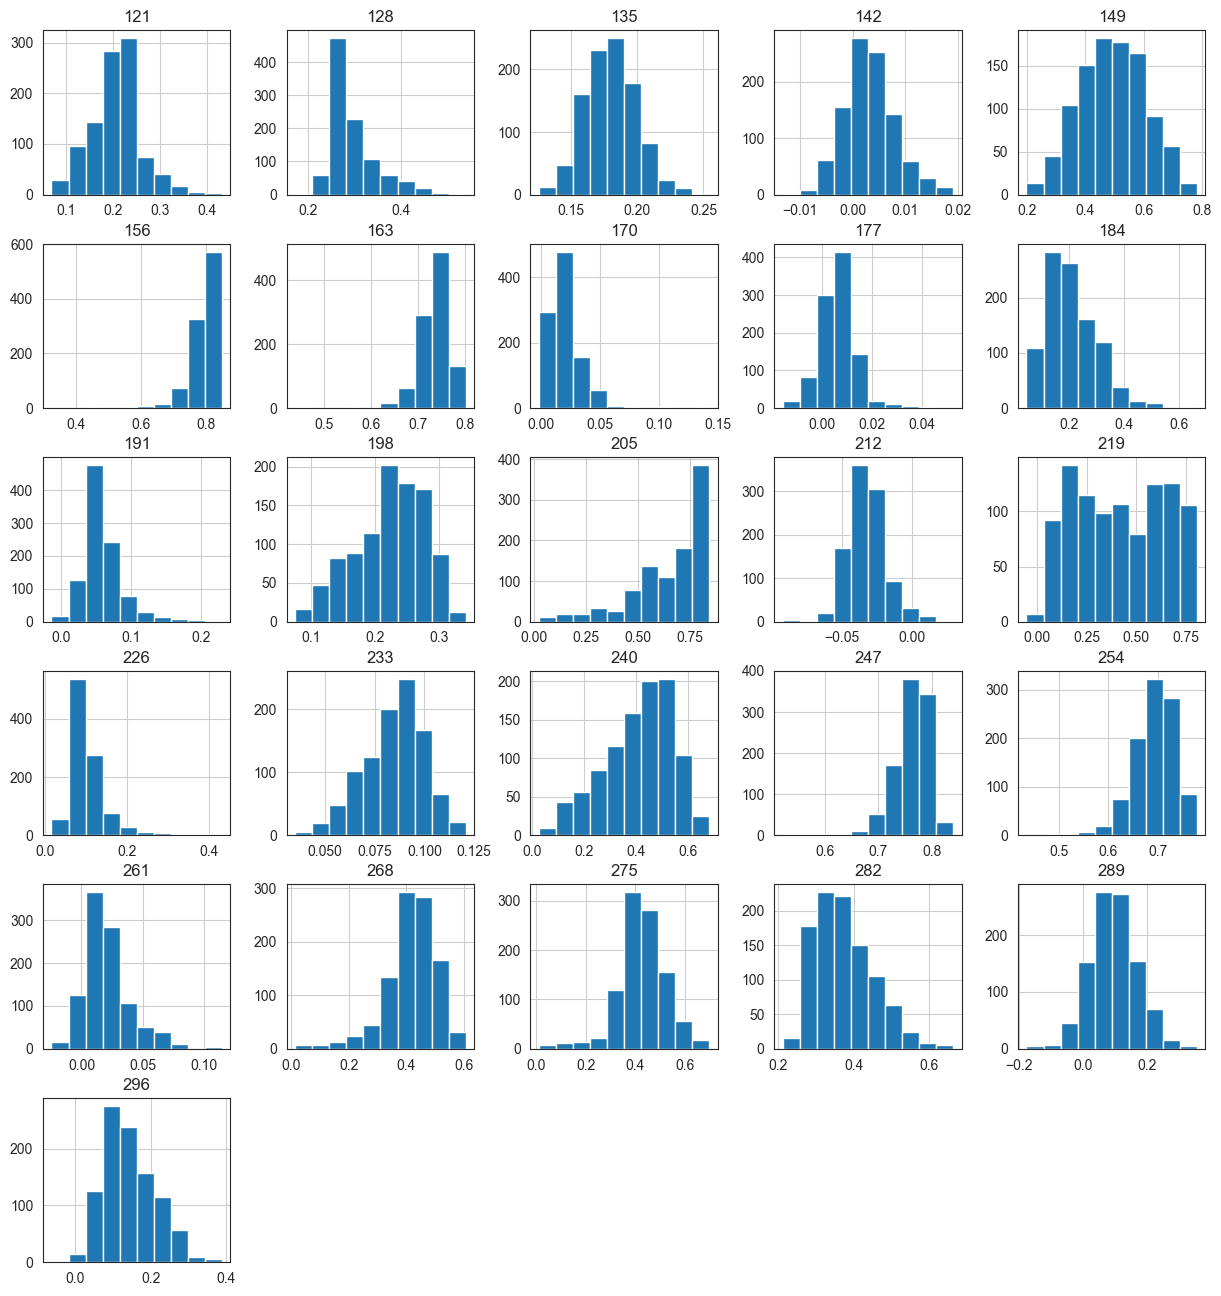

In [39]:
forest_ndvi.hist(figsize=(15,16))
plt.show()

Как видно из распределений признаков, в некоторые дни наблюдается низкое значение NDVI. Также среди графиков имеются распределения с большим разбросом (к примеру от 0 до 0.7). Это произошло потому, что на спутниковых снимки, которые мы обрабатывали, попали облака с той или иной степенью плотности. Чем больше облачность, тем меньше NDVI. Чтобы обработать такие аномалии нужно установить значения NDVI, ниже которых наблюдение будет считаться аномальным.

Может быть 2 случая:
- Полная облачность: распределение состоит полностью из близких к нулю значений;
- Частичная облчность: в распределении есть значения близкие к 1 или имеется высокий разброс (кроме распределений первого и последнего дней).

Минимальные значения устанавливались по следующим принципам:
- Брать значения близ вершины распределения;
- Если вершин много, берутся значения близ правой вершины;
- Если распределение построено на значениях близких к нулю, то нужно ориентироваться на ближайшие "безоблачные" распределения.

Все аномальные значения заменим пустыми.

In [40]:
cloud_filter = {'121': 0.14, '128': 0.22, '135': 0.22,
                '142': 0.22, '149': 0.5, '156': 0.61,
                '163': 0.62, '170': 0.62, '177': 0.62,
                '184': 0.62, '191': 0.62, '198': 0.62,
                '205': 0.6, '212': 0.6, '219': 0.6,
                '226': 0.6, '233': 0.6, '240': 0.6,
                '247': 0.68, '254': 0.61, '261': 0.61,
                '268': 0.3, '275': 0.29, '282': 0.2,
                '289': 0.1, '296': 0.06}

for column in forest_ndvi.columns:
    forest_ndvi[column] = forest_ndvi[column].apply(
        lambda ndvi: np.nan if ndvi < cloud_filter[column] else ndvi
    )

Пустные значения заполняем линейной интерполяцией. Кроме этого нужно будет сгладить временной ряд с помощью фильтра Савицкого–Голея.

In [41]:
#интерполяция
mask = forest_ndvi['121'] != forest_ndvi['121'] # при заполнении с первой ячейки пропуски вначале останутся
forest_ndvi[mask] = forest_ndvi[mask].interpolate(method='linear', limit_direction='backward', axis=1) # поэтому используем заполнение с последней
forest_ndvi = forest_ndvi.interpolate(method='linear', axis=1)

# сглаживание
for i, row in forest_ndvi.iterrows():
    forest_ndvi.iloc[i, :] = savgol_filter(row, 13, 3)

forest_ndvi = pd.concat([forest_ndvi, pd.DataFrame(np.full(shape=(forest_ndvi.shape[0], 1), fill_value='лес'), columns=['Culture'])], axis=1)

Объединяем новые данные и получаем **итоговый датасет:**

In [42]:
df = pd.concat([orig_df, forest_ndvi], axis=0).reset_index(drop=True)
df

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture
0,0.152669,0.174438,0.209893,0.256847,0.311688,0.369805,0.426172,0.475995,0.515328,0.541544,...,0.408483,0.385844,0.365548,0.346269,0.326351,0.304307,0.279290,0.251440,0.222043,рапс
1,0.084050,0.086133,0.108377,0.150274,0.207985,0.274870,0.342531,0.402199,0.446191,0.469186,...,0.205599,0.198665,0.203006,0.213593,0.224371,0.229603,0.225114,0.209236,0.183238,овёс
2,0.096446,0.126057,0.176833,0.242489,0.314037,0.381269,0.434477,0.466086,0.471930,0.451926,...,0.172827,0.199820,0.232640,0.262798,0.282596,0.286615,0.272769,0.242751,0.201755,ячмень
3,0.179056,0.218924,0.273501,0.337271,0.403364,0.464549,0.514283,0.547656,0.562066,0.557534,...,0.345934,0.347316,0.351494,0.353862,0.350224,0.337656,0.315155,0.283937,0.247342,рапс
4,0.079677,0.089905,0.117176,0.159635,0.213100,0.271661,0.328564,0.377248,0.412350,0.430514,...,0.240325,0.233890,0.234504,0.238449,0.241388,0.239296,0.229331,0.210486,0.183892,овёс
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12942,0.205933,0.381448,0.517225,0.617524,0.686606,0.728729,0.748154,0.751982,0.735962,0.708976,...,0.728132,0.719693,0.677847,0.621374,0.556706,0.487770,0.418491,0.352792,0.294599,лес
12943,0.164784,0.335841,0.472899,0.579638,0.659736,0.716875,0.754733,0.791084,0.807716,0.797484,...,0.695211,0.687109,0.644822,0.584808,0.513867,0.434643,0.349779,0.261921,0.173710,лес
12944,0.142319,0.331536,0.478763,0.588592,0.665619,0.714438,0.739642,0.750905,0.739677,0.716870,...,0.752665,0.746540,0.691401,0.624668,0.546942,0.462024,0.373714,0.285813,0.202120,лес
12945,0.150778,0.317683,0.452830,0.559238,0.639923,0.697902,0.736192,0.764459,0.769754,0.760947,...,0.735569,0.704659,0.650429,0.574735,0.487194,0.390530,0.287464,0.180718,0.073013,лес


## Анализ и очистка данных

Рассмотрим, как выглядит временной ряд у каждой культуры (возьмем среднее по каждому дню).

In [43]:
# функция для визуализации временных рядов
def create_plot(df_viz, title):
    cul = list(df['Culture'].unique().tolist())

    fig, ax = plt.subplots(figsize=(10,8))

    plt.yticks(fontsize=10)

    ax.set_xlabel('Дни от начала года',fontsize = 10,fontweight="bold")
    ax.set_ylabel('Средний NDVI',fontsize = 16,fontweight="bold")
    ax.patch.set_edgecolor('black')

    ax.patch.set_linewidth(1)
    plt.ylim([0.1, 0.9])


    xx= ['121', '128', '135', '142', '149', '156', '163', '170', '177', '184', '191', '198', '205', '212', '219', '226', '233', '240', '247', '254', '261', '268', '275', '282', '289', '296']
    colors = list(plt.cm.tab10.colors)
    colors.extend(list(plt.cm.Set3.colors))
    for i in range(len(cul)):
        p = df_viz.loc[(df_viz['Culture'] == cul[i])].drop(columns=['Culture']).mean()
        ax.plot(xx, p.values.tolist(), label=cul[i], linestyle = '-', marker = 's', markersize = 6, linewidth = 2, color=colors[i])
    plt.yticks(size=10, fontweight="bold")
    leg = ax.legend(fontsize=9, loc ='upper right')
    ax.set_title(title)

    plt.show()

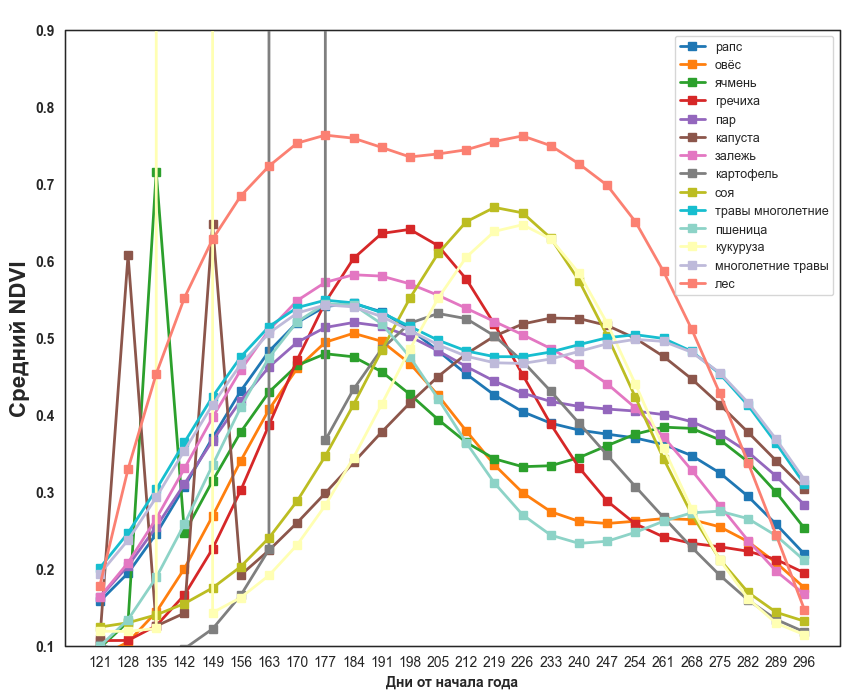

In [44]:
create_plot(df, 'Временные ряды культур по среднему индексу NDVI')

Из графика видно, что данные "сырые":
- «взрыв линий» в начале графика свидетельствует о том, что среди данных присутствуют большие показатели NDVI;
- некоторые культуры друг на друга похожи, что плохо скажется на будущей модели;
- среди изначальных 12 категорий появилась еще одна – *«травы многолетние»*. Очевидно, это часть данных *«многолетние травы»*.


In [45]:
df['Culture'].value_counts()

Culture
залежь               999
лес                  999
рапс                 998
гречиха              998
картофель            997
соя                  997
ячмень               996
овёс                 995
капуста              994
пар                  993
пшеница              993
кукуруза             992
многолетние травы    933
травы многолетние     63
Name: count, dtype: int64

Почти все культуры примерно равны по своей численности. Согласно изначальному списку, категории *«травы многолетние»* не может быть, следовательно, необходимо обратить эту категорию в *«многолетние травы»*. По итогу кол-во *«многолетних трав»* должно стать равным 996.

In [46]:
df['Culture'] = df['Culture'].apply(lambda cult: 'многолетние травы' if cult=='травы многолетние' else cult)

df['Culture'].value_counts()

Culture
залежь               999
лес                  999
рапс                 998
гречиха              998
картофель            997
соя                  997
ячмень               996
многолетние травы    996
овёс                 995
капуста              994
пар                  993
пшеница              993
кукуруза             992
Name: count, dtype: int64

Рассмотрим общую статистику.

In [47]:
df_dis = df.describe()

df_dis

,121,128,135,142,149,156,163,170,177,184,...,233,240,247,254,261,268,275,282,289,296
count,12947.000000,12939.000000,12938.000000,1.294500e+04,12942.000000,12942.000000,12943.000000,1.294400e+04,12946.000000,12947.000000,...,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000,12947.000000
mean,0.130708,0.199587,0.243152,8.673748e+10,0.338970,0.354805,0.404834,2.582756e+11,0.483956,0.507881,...,0.459088,0.439072,0.418526,0.395703,0.369913,0.341019,0.308910,0.274129,0.237966,0.202394
std,0.046250,4.298159,4.658956,9.868651e+12,4.219190,0.155663,0.157240,2.938446e+13,0.140531,0.124750,...,0.160721,0.153724,0.142771,0.130027,0.119655,0.113804,0.110262,0.105513,0.097729,0.088844
min,0.000000,-0.020791,-0.034452,-3.155709e-02,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.095657,0.105078,0.121372,1.456189e-01,0.176992,0.216126,0.265466,3.322265e-01,0.396214,0.434644,...,0.355149,0.329945,0.307989,0.291674,0.275210,0.253706,0.228069,0.200413,0.170451,0.134825
50%,0.123457,0.142341,0.180969,2.387498e-01,0.304169,0.368631,0.426243,4.713859e-01,0.508246,0.523466,...,0.449666,0.435625,0.417396,0.389136,0.357841,0.323949,0.291503,0.260434,0.224130,0.188317
75%,0.160450,0.204654,0.257322,3.188511e-01,0.383656,0.446310,0.500123,5.392776e-01,0.563700,0.578646,...,0.569534,0.548505,0.511868,0.478590,0.441003,0.415517,0.384480,0.344563,0.299287,0.258306
max,0.619902,489.000000,530.000000,1.122817e+15,480.000000,0.758795,0.789819,3.343120e+15,0.840099,0.836991,...,0.839557,0.813252,0.797089,0.770441,0.752933,0.715353,0.656514,0.616112,0.582805,0.532402


In [48]:
# NDVI лежит в диапазоне от -1 до 1, следовательно, показатели не должны выходить за диапазон
mask = (df_dis.loc['mean'] > 1) | (df_dis.loc['mean'] < -1)
df_dis.loc['mean'][mask]

142    8.673748e+10
170    2.582756e+11
Name: mean, dtype: float64

In [49]:
mask = (df_dis.loc['max'] > 1) | (df_dis.loc['max'] < -1)
df_dis.loc['max'][mask]

128    4.890000e+02
135    5.300000e+02
142    1.122817e+15
149    4.800000e+02
170    3.343120e+15
Name: max, dtype: float64

В данных содержатся аномальные значения, которые выбиваются из стандартного диапазона NDVI. Нужно заменить такие значения на пустые и задача превращается уже в обработку пустых значений.

In [50]:
# датасет без таргета
df_ts = df.iloc[:, :-1]

for column in df_ts.columns:
    df_ts[column] = df_ts[column].apply(lambda x: np.nan if x < -1 or x > 1 else x)

Обрабатываться они также будут с помощью линейной интерполяции.

In [51]:
df.iloc[:, :-1] = df_ts.interpolate(method='linear', limit_direction='forward', axis=1)

# проверка на пустые значения в данных
df[df.isnull().any(axis=1)]

,121,128,135,142,149,156,163,170,177,184,...,240,247,254,261,268,275,282,289,296,Culture


Последним этапом в очистке данных будет являться удаление дубликатов.

In [52]:
df = df.drop_duplicates().reset_index(drop=True)

**Очищенные данные:**

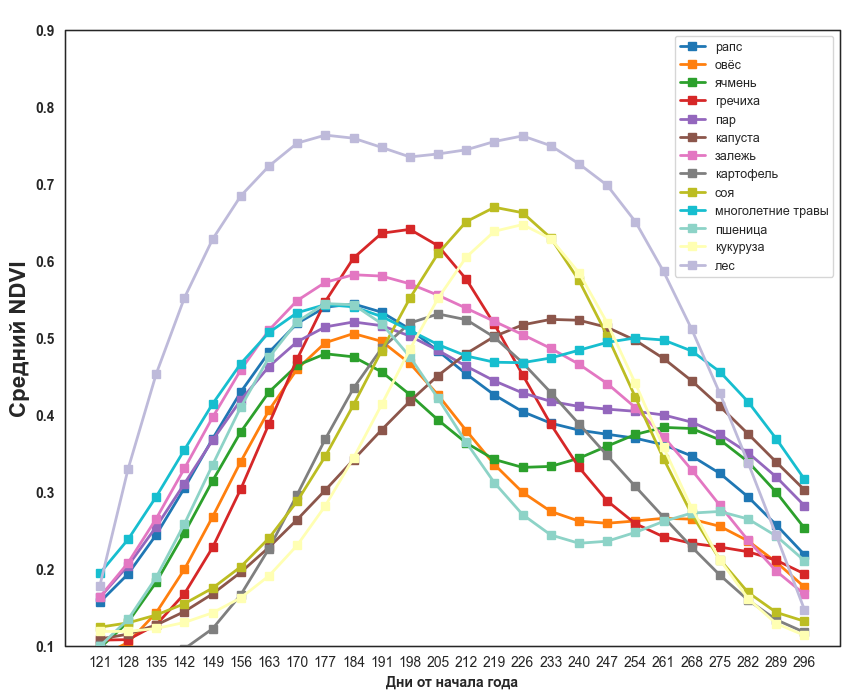

,121,128,135,142,149,156,163,170,177,184,...,233,240,247,254,261,268,275,282,289,296
count,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,...,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000
mean,0.131561,0.165470,0.208188,0.257671,0.310970,0.364565,0.414813,0.458966,0.493244,0.516336,...,0.463734,0.442871,0.421357,0.397222,0.369865,0.339355,0.305701,0.269562,0.232311,0.195964
std,0.047845,0.079274,0.110440,0.134654,0.151062,0.159508,0.160063,0.154361,0.141490,0.125011,...,0.168233,0.160279,0.148256,0.134263,0.122743,0.116121,0.112058,0.106769,0.098305,0.088948
min,0.000000,-0.020791,-0.034452,-0.031557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.094824,0.105727,0.124379,0.150641,0.185676,0.234140,0.282719,0.344663,0.408265,0.443563,...,0.351415,0.324844,0.303330,0.286525,0.272911,0.251028,0.225077,0.195609,0.164371,0.130561
50%,0.124617,0.144954,0.185346,0.244519,0.309363,0.373535,0.431463,0.476369,0.512190,0.526192,...,0.454895,0.440226,0.422190,0.390368,0.355374,0.318632,0.284329,0.253120,0.216784,0.178425
75%,0.161993,0.210430,0.264238,0.326356,0.391295,0.453295,0.506661,0.545337,0.568903,0.583371,...,0.589207,0.559845,0.514975,0.478183,0.438937,0.411841,0.379949,0.336812,0.289170,0.246215
max,0.619902,0.623697,0.626390,0.648061,0.714097,0.758795,0.789819,0.818612,0.840099,0.836991,...,0.839557,0.813252,0.797089,0.770441,0.752933,0.715353,0.656514,0.616112,0.582805,0.532402


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10640 entries, 0 to 10639
Data columns (total 27 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   121      10640 non-null  float64
 1   128      10640 non-null  float64
 2   135      10640 non-null  float64
 3   142      10640 non-null  float64
 4   149      10640 non-null  float64
 5   156      10640 non-null  float64
 6   163      10640 non-null  float64
 7   170      10640 non-null  float64
 8   177      10640 non-null  float64
 9   184      10640 non-null  float64
 10  191      10640 non-null  float64
 11  198      10640 non-null  float64
 12  205      10640 non-null  float64
 13  212      10640 non-null  float64
 14  219      10640 non-null  float64
 15  226      10640 non-null  float64
 16  233      10640 non-null  float64
 17  240      10640 non-null  float64
 18  247      10640 non-null  float64
 19  254      10640 non-null  float64
 20  261      10640 non-null  float64
 21  268      106

None

In [53]:
create_plot(df, 'Очищенные временные ряды культур по среднему индексу NDVI')
display(df.describe())
display(df.info())

Данные готовы для подачи в модель.

## Подготовка данных

Рассмотрим, соотношение классов в целевом признаке.

In [ ]:
df['Culture'].value_counts(normalize=True)*100

Culture
лес                  9.389098
соя                  9.285714
залежь               9.154135
овёс                 8.712406
ячмень               8.430451
многолетние травы    8.402256
пшеница              8.082707
кукуруза             7.800752
картофель            7.706767
пар                  7.349624
гречиха              6.889098
рапс                 4.906015
капуста              3.890977
Name: proportion, dtype: float64

Наблюдается дисбаланс выборки. Необходимо:
- стратифицированное разбираение;
- взвешивание классов внутри моделей, если это возможно.

In [ ]:
X = df.drop(columns=['Culture'])
y = df['Culture']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

В качестве моделей будут использоваться алгоритмы:
- **LogisticRegression с полиномом 3 степени**;
- **GaussianNB**;
- **RandomForest**;
- **LightGBM**.

## LogisticRegression

Обучим LogisticRegression с полиномом 3 степени без регуляризации.

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr = LogisticRegression(
    penalty=None,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr.fit(X_train_poly, y_train)

y_lr_pred = lr.predict(X_test_poly)

## GaussianNB

Внутри модели GaussianNB нет метода взвешивания классов, однако есть еще один способ борьбы с проблемой дисбаланса - сэмплирование. С помощью специального метода SMOTE мы сгенерируем новые объекты, чтобы классы стали равны по кол-ву.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts(normalize=True)*100

Culture
ячмень               7.692308
картофель            7.692308
пшеница              7.692308
гречиха              7.692308
многолетние травы    7.692308
овёс                 7.692308
лес                  7.692308
пар                  7.692308
кукуруза             7.692308
рапс                 7.692308
соя                  7.692308
капуста              7.692308
залежь               7.692308
Name: proportion, dtype: float64

Все классы занимают одинаковый процент в данных.

In [ ]:
gnb = GaussianNB()

gnb.fit(X_train_resampled, y_train_resampled)

y_gnb_pred = gnb.predict(X_test)

## RandomForest

Для того, чтобы подбирать гиперпараметры остальных моделей, был использован специальный фреймворк **Optuna**. В нем реализовано несколько алгоритмов оптимизации, самый популярный из к-х метод байесовской оптимизации - [Tree of Parzen Estimators (TPE)](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

На начальном этапе необходимо определить функцию, к-я строится по следующему принципу:
- формируется пространство поиска параметров с помощью аргумента *trial*;
- проводится кросс-валидация модели с заданными гиперпараметрами;
- функция возвращает результат кросс-валидации.

Наша целевая метрика: **F1-macro** (средний F1 по всем классам).

Функция подается в оптимизатор, где гиперпараметры подбираются таким образом, чтобы возращаемое(-ые) функцией значение(-ия) было максимальным (минимальным).

In [ ]:
def opt_forest(trial):
    
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 10, 30, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    
    model = RandomForestClassifier(
        n_estimators=500,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', # взвешивание классов
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(
        model, X_train, y_train,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

In [ ]:
forest_study = opt.create_study(study_name='RandomForest', direction='maximize')
forest_study.optimize(opt_forest, n_trials=50, n_jobs=-1)
print('Best params:', forest_study.best_params)

[I 2024-06-03 02:14:18,744] A new study created in memory with name: RandomForest
[I 2024-06-03 02:15:04,900] Trial 0 finished with value: 0.8949416860165718 and parameters: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8949416860165718.
[I 2024-06-03 02:15:05,913] Trial 1 finished with value: 0.8843464590983471 and parameters: {'criterion': 'log_loss', 'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8949416860165718.
[I 2024-06-03 02:15:31,559] Trial 3 finished with value: 0.8771687745967691 and parameters: {'criterion': 'gini', 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8949416860165718.
[I 2024-06-03 02:15:40,917] Trial 2 finished with value: 0.8982172548226984 and parameters: {'criterion': 'log_loss', 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8982172548226984.
[I 2024-06-03 02:16:11,901] Trial 8 finished with value: 0.8877725519155583 and parameters: {'

Best params: {'criterion': 'entropy', 'max_depth': 22, 'min_samples_leaf': 1}


In [ ]:
forest = RandomForestClassifier(
    **forest_study.best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

forest.fit(X_train, y_train)

y_forest_pred = forest.predict(X_test)

## LightGBM

In [ ]:
def opt_lgbm(trial):
    
    num_leaves = trial.suggest_int('num_leaves', 20, 200, step=5)
    max_depth = trial.suggest_int('max_depth', 3, 20, step=1)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 10, step=1)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)
    
    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        objective='multiclass',
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(
        model, X_train, y_train,
        scoring='f1_macro',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

In [ ]:
lgbm_study = opt.create_study(study_name='LightGBM', direction='maximize')
lgbm_study.optimize(opt_lgbm, n_trials=50, n_jobs=-1)
print('Best params:', lgbm_study.best_params)

[I 2024-06-03 02:28:25,669] A new study created in memory with name: LightGBM
[I 2024-06-03 02:28:35,130] Trial 1 finished with value: 0.8953788944071819 and parameters: {'num_leaves': 140, 'max_depth': 4, 'min_child_samples': 8, 'n_estimators': 140}. Best is trial 1 with value: 0.8953788944071819.
[I 2024-06-03 02:28:54,727] Trial 3 finished with value: 0.9020602454877921 and parameters: {'num_leaves': 45, 'max_depth': 7, 'min_child_samples': 3, 'n_estimators': 250}. Best is trial 3 with value: 0.9020602454877921.
[I 2024-06-03 02:29:14,184] Trial 0 finished with value: 0.8708439352085419 and parameters: {'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 9, 'n_estimators': 50}. Best is trial 3 with value: 0.9020602454877921.
[I 2024-06-03 02:29:17,692] Trial 6 finished with value: 0.8976847161640429 and parameters: {'num_leaves': 120, 'max_depth': 4, 'min_child_samples': 6, 'n_estimators': 230}. Best is trial 3 with value: 0.9020602454877921.
[I 2024-06-03 02:29:32,621] Trial 2 f

Best params: {'num_leaves': 45, 'max_depth': 7, 'min_child_samples': 3, 'n_estimators': 250}


In [ ]:
lgbm = LGBMClassifier(
    **lgbm_study.best_params,
    objective='multiclass',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

y_lgbm_pred = lgbm.predict(X_test)

## Результаты

In [ ]:
# LogisticRegression
print(classification_report(y_test, y_lr_pred))

                   precision    recall  f1-score   support

          гречиха       0.96      0.90      0.93       147
           залежь       0.80      0.84      0.82       195
          капуста       0.88      0.99      0.93        83
        картофель       0.82      0.89      0.85       164
         кукуруза       0.88      0.89      0.88       166
              лес       1.00      0.99      1.00       200
многолетние травы       0.90      0.73      0.80       179
             овёс       0.82      0.79      0.80       185
              пар       0.76      0.89      0.82       156
          пшеница       0.79      0.82      0.81       172
             рапс       0.80      0.95      0.87       104
              соя       0.88      0.77      0.82       198
           ячмень       0.96      0.89      0.92       179

         accuracy                           0.86      2128
        macro avg       0.87      0.87      0.87      2128
     weighted avg       0.87      0.86      0.86      

In [ ]:
# GaussianNB
print(classification_report(y_test, y_gnb_pred))

                   precision    recall  f1-score   support

          гречиха       0.96      0.88      0.92       147
           залежь       0.72      0.82      0.77       195
          капуста       0.80      0.96      0.87        83
        картофель       0.81      0.71      0.75       164
         кукуруза       0.62      0.80      0.70       166
              лес       1.00      0.99      0.99       200
многолетние травы       0.69      0.66      0.67       179
             овёс       0.66      0.63      0.65       185
              пар       0.65      0.65      0.65       156
          пшеница       0.69      0.77      0.73       172
             рапс       0.65      0.89      0.76       104
              соя       0.74      0.55      0.63       198
           ячмень       0.75      0.54      0.63       179

         accuracy                           0.74      2128
        macro avg       0.75      0.76      0.75      2128
     weighted avg       0.75      0.74      0.74      

In [ ]:
# RandomForest
print(classification_report(y_test, y_forest_pred))

                   precision    recall  f1-score   support

          гречиха       0.96      0.92      0.94       147
           залежь       0.82      0.89      0.85       195
          капуста       0.93      0.98      0.95        83
        картофель       0.86      0.91      0.88       164
         кукуруза       0.94      0.90      0.92       166
              лес       0.99      0.99      0.99       200
многолетние травы       0.90      0.85      0.88       179
             овёс       0.84      0.80      0.82       185
              пар       0.87      0.93      0.90       156
          пшеница       0.85      0.83      0.84       172
             рапс       0.88      0.96      0.92       104
              соя       0.91      0.85      0.88       198
           ячмень       0.97      0.93      0.95       179

         accuracy                           0.90      2128
        macro avg       0.90      0.90      0.90      2128
     weighted avg       0.90      0.90      0.90      

In [ ]:
# LightGBM
print(classification_report(y_test, y_lgbm_pred))

                   precision    recall  f1-score   support

          гречиха       0.99      0.89      0.94       147
           залежь       0.80      0.88      0.84       195
          капуста       0.93      0.95      0.94        83
        картофель       0.86      0.90      0.88       164
         кукуруза       0.93      0.92      0.93       166
              лес       1.00      0.99      1.00       200
многолетние травы       0.92      0.85      0.89       179
             овёс       0.79      0.82      0.81       185
              пар       0.88      0.92      0.90       156
          пшеница       0.84      0.82      0.83       172
             рапс       0.90      0.97      0.94       104
              соя       0.90      0.86      0.88       198
           ячмень       0.98      0.96      0.97       179

         accuracy                           0.90      2128
        macro avg       0.90      0.90      0.90      2128
     weighted avg       0.90      0.90      0.90      

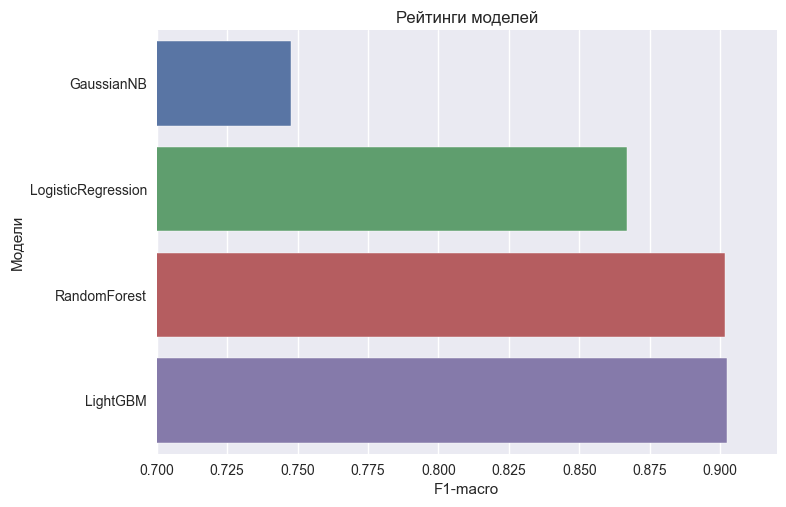

In [ ]:
ratings = pd.DataFrame({'GaussianNB': [f1_score(y_test, y_gnb_pred, average='macro')],
                        'LogisticRegression': [f1_score(y_test, y_lr_pred, average='macro')],
                        'RandomForest': [f1_score(y_test, y_forest_pred, average='macro')],
                        'LightGBM': [f1_score(y_test, y_lgbm_pred, average='macro')]})

sns.barplot(ratings, orient='h')
plt.title('Рейтинги моделей')
plt.xlabel('F1-macro')
plt.ylabel('Модели')
plt.xlim(0.7, 0.92)
plt.style.use('seaborn-v0_8')

(0.9, 0.92)

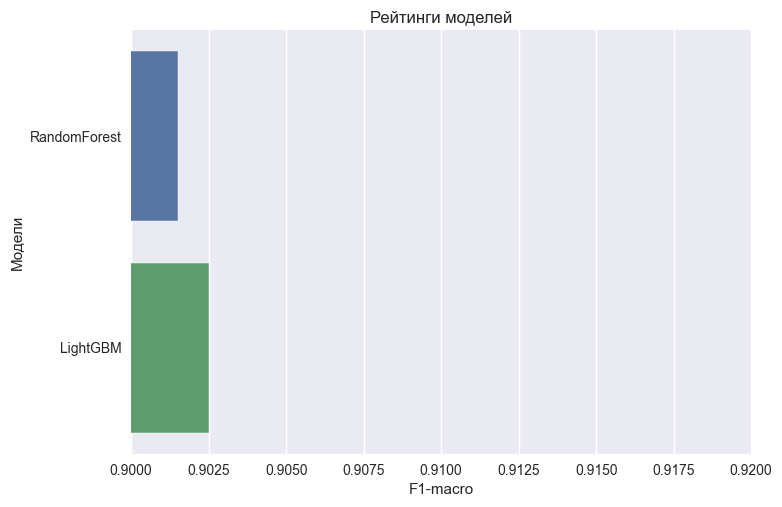

In [ ]:
sns.barplot(ratings[['RandomForest', 'LightGBM']], orient='h')
plt.title('Рейтинги моделей')
plt.xlabel('F1-macro')
plt.ylabel('Модели')
plt.xlim(0.9, 0.92)

C небольшим отрывом **LightGBM** обогнала **RandomForest** по целевой метрике, все остальные алгоритмы сильно отстают. Результат финальной модели **~0.9025**, что является очень хорошим показателем.

Хуже всего модель определяла классы *овёс* (~0.81) и *пшеница* (~0.83). Лучше всего: *рапс*, *капусту*, *гречиху* (~0.94) и *ячмень* (~0.97). Практически идеально определяет класс *лес* (~1.0).